In [15]:
%matplotlib inline
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from opto_untils import session_dirs, makedirs
from plot_untils import shiftedColorMap, template_reorder, plot_raster_bar, merge_pdfs, interpolate_waveform
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from scipy.signal import butter, filtfilt

# Create a white-to-bright red colormap
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
my_red = LinearSegmentedColormap.from_list("white_to_red", colors)

colors = ['blue', 'white', 'red']
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

In [16]:
def make_combine_folder(exp_name):
    # Create a new folder to store combined files
    scratch_dir = '/root/capsule/scratch'
    combined_folder_path = os.path.join(scratch_dir, exp_name)
    wf_figs_path = os.path.join(combined_folder_path, 'waveform_figs')
    wf_combined_info_path = os.path.join(combined_folder_path, 'waveform_combined_info')
    if not os.path.exists(combined_folder_path):
        os.makedirs(combined_folder_path)
    combined_dirs = {
        'combined_folder_path': combined_folder_path,
        'wf_figs_path': wf_figs_path,
        'wf_combined_info_path': wf_combined_info_path
    }
    makedirs(combined_dirs)
    return combined_dirs

In [17]:
# session_file = '/root/capsule/code/data_management/np_opto_assets.csv'
session_file = '/root/capsule/code/data_management/np2.0_tag.csv'
session_df = pd.read_csv(session_file)
session_ids = session_df['session_id'].values
print(session_ids)
combined_dirs = make_combine_folder(exp_name = 'all_wf_NP2.0')

['ecephys_713854_2024-03-05_12-01-40' 'ecephys_713854_2024-03-05_13-01-09'
 'ecephys_713854_2024-03-05_13-31-20' 'ecephys_717120_2024-03-06_12-23-53'
 'ecephys_717120_2024-03-06_12-54-27' 'ecephys_717120_2024-03-07_12-12-02'
 'ecephys_713854_2024-03-08_14-54-25' 'ecephys_713854_2024-03-08_15-43-01'
 'ecephys_713854_2024-03-08_16-20-33' 'ecephys_713854_2024-03-08_17-15-58']


### Gather all wavefroms, depth, channel number and qc

In [18]:
def high_pass_filter(data, cutoff_freq, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data, axis=1)

In [19]:
def band_pass_filter(data, low, high, fs, order=5):
    nyquist = 0.5 * fs
    low = low / nyquist
    high = high / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return filtfilt(b, a, data, axis=1)

In [20]:
# Extract waveforms
# set parameters
filter_order = 3
resp_win = 25/1000   
y_neighbors_to_keep = 2
samples_to_keep = [-20, 40]
selection = 'all' # 'all' or 'major'
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)
# load waveforms
all_wf = [] 
all_wf_inter = []
session_ids_all = []
unit_ids_all = []
all_amps = []
for session_ind, session_id in enumerate(session_ids):
    session_dir = session_dirs(session_id)
    we = si.load_waveforms(session_dir['postprocessed_dir'], with_recording=False)
    unit_ids = we.sorting.get_unit_ids()
    all_templates = we.get_all_templates()
    # amplitude
    curr_amps = np.reshape(all_templates, (np.shape(all_templates)[0], -1)).min(axis=1)
    # filter all templates
    all_templates = high_pass_filter(all_templates, 300, 30000, order=filter_order)
    all_channels = we.sparsity.channel_ids
    if 'AP' in all_channels[0]:
        all_channels_int = np.array([int(channel.split('AP')[-1]) for channel in all_channels])
    else:
        all_channels_int = np.array([int(channel.split('CH')[-1]) for channel in all_channels])
    unit_spartsiity = we.sparsity.unit_id_to_channel_ids
    channel_locations = we.get_channel_locations()
    unit_locations = we.load_extension("unit_locations").get_data(outputs="by_unit")
    right_left = channel_locations[:, 0]<20

    channel_loc_dict = {channel: channel_loc for channel, channel_loc in zip(all_channels_int, channel_locations)}

    # save all re-ordered templates
    print(session_id)
    for unit_ind, unit_id in enumerate(unit_ids):
        curr_template = all_templates[unit_ind]
        reordered_template = template_reorder(curr_template, right_left, all_channels_int, sample_to_keep = samples_to_keep, y_neighbors_to_keep = y_neighbors_to_keep, orginal_loc = False)
        np.save(os.path.join(session_dir['opto_tag_dir'], f'unit_waveform_{unit_id}.npy'), reordered_template)  
        reordered_template_norm = reordered_template/np.nanmin(reordered_template)
        all_wf.append(reordered_template_norm)
        # interplate waveform
        waveform_temp = template_reorder(curr_template, right_left, all_channels_int, sample_to_keep = samples_to_keep, y_neighbors_to_keep = 5, orginal_loc = False)
        waveform_interpolated = interpolate_waveform(waveform_temp)
        waveform_interpolated= waveform_interpolated[5-y_neighbors_to_keep:5+y_neighbors_to_keep+1,:]
        waveform_interpolated_norm = waveform_interpolated/np.nanmin(waveform_interpolated)
        all_wf_inter.append(waveform_interpolated_norm)
        session_ids_all.append(session_id)
        # print(f'Session {session_id} Unit {unit_id}')    
    unit_ids_all+= list(unit_ids)
    all_amps = np.concatenate([all_amps, curr_amps])          

ecephys_713854_2024-03-05_12-01-40
ecephys_713854_2024-03-05_13-01-09
ecephys_713854_2024-03-05_13-31-20
ecephys_717120_2024-03-06_12-23-53
ecephys_717120_2024-03-06_12-54-27
ecephys_717120_2024-03-07_12-12-02
ecephys_713854_2024-03-08_14-54-25
ecephys_713854_2024-03-08_15-43-01
ecephys_713854_2024-03-08_16-20-33
ecephys_713854_2024-03-08_17-15-58


In [21]:
np.shape(all_amps)

(1570,)

In [22]:
# Extract location
all_depth = []
for session_id in session_ids:
    session_dir = session_dirs(session_id)
    we = si.load_waveforms(session_dir['postprocessed_dir'], with_recording=False)
    unit_ids = we.sorting.get_unit_ids()
    all_templates = we.get_all_templates()
    all_channels = we.sparsity.channel_ids  
    if 'AP' in all_channels[0]:
        all_channels_int = np.array([int(channel.split('AP')[-1]) for channel in all_channels])
    else:
        all_channels_int = np.array([int(channel.split('CH')[-1]) for channel in all_channels])
    unit_spartsiity = we.sparsity.unit_id_to_channel_ids
    channel_locations = we.get_channel_locations()
    unit_locations = we.load_extension("unit_locations").get_data(outputs="by_unit")
    curr_unit_depth = [unit_locations[unit_id][1] for unit_id in unit_ids]

    all_depth+=curr_unit_depth

    print(f'Session {session_id}')                                

Session ecephys_713854_2024-03-05_12-01-40
Session ecephys_713854_2024-03-05_13-01-09
Session ecephys_713854_2024-03-05_13-31-20
Session ecephys_717120_2024-03-06_12-23-53
Session ecephys_717120_2024-03-06_12-54-27
Session ecephys_717120_2024-03-07_12-12-02
Session ecephys_713854_2024-03-08_14-54-25
Session ecephys_713854_2024-03-08_15-43-01
Session ecephys_713854_2024-03-08_16-20-33
Session ecephys_713854_2024-03-08_17-15-58


In [23]:
def opto_qc(session_id, unit_id, baseline, resp_thresh, resp_count_thresh, resp_lat_thresh, target = 'soma'):
    session_dir = session_dirs(session_id)
    opto_df = pd.read_csv(os.path.join(session_dir['opto_tag_dir'], session_id+'_opto_session.csv'))
    opto_info_file = os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_info_{target}.json')
    unit_spikes = np.load(os.path.join(session_dir['opto_tag_dir'], f'spiketimes_{int(unit_id)}.npy'))
    with open(opto_info_file) as f:
        opto_info = json.load(f)
    opto_resp_file = os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_p_{target}_{int(unit_id)}.npy')
    opto_resp = np.load(opto_resp_file, allow_pickle=True)
    opto_lat_file = os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_lat_{target}_{int(unit_id)}.npy')
    opto_lat = np.load(opto_lat_file, allow_pickle=True)

    # find best location
    mean_resp = np.full(np.shape(opto_resp), np.nan)
    for power_ind in range(np.shape(opto_resp)[0]):
        for site_ind in range(np.shape(opto_resp)[1]):
            for num_ind in range(np.shape(opto_resp)[2]):
                for duration_ind in range(np.shape(opto_resp)[3]):
                    for freq_ind in range(np.shape(opto_resp)[4]):
                        mean_resp[power_ind, site_ind, num_ind, duration_ind, freq_ind] = np.nanmean(np.array(opto_resp[power_ind, site_ind, num_ind, duration_ind, freq_ind]))

    resp_best_ind = np.argmax(mean_resp)
    multi_index = np.unravel_index(resp_best_ind, mean_resp.shape)
    p_list = np.array(opto_resp[multi_index])
    lat_list = np.array(opto_lat[multi_index])
    
    if np.sum(np.mean(p_list>=resp_thresh)>=resp_count_thresh and np.nanmean(lat_list)<resp_lat_thresh):
        return True, p_list, lat_list
    else:
        return False, p_list, lat_list

# session_id = session_ids[0]
# session_dir = session_dirs(session_id)
# sorting = si.load_extractor(session_dir['curated_dir'])
# unit_ids = sorting.get_unit_ids()
# unit_id = unit_ids[80]

# opto_qc(session_id, unit_id, 0, resp_thresh, resp_count_thresh, resp_lat_thresh)

In [24]:
# load quality metrics from nwb
# unit op_qc threshold
target = 'soma'
resp_count_thresh = 1
resp_lat_thresh = 25/1000
resp_thresh = 0.4
resp_win = 25/1000
all_qc = []
op_pass_all = []
p_all = []
lat_all = []
for session_id in session_ids:
    session_dir = session_dirs(session_id)
    # load quality metrics
    if os.path.exists(session_dir['nwb_dir']):
        nwb = load_nwb(session_dir['nwb_dir'])
        unit_qc = nwb.units[:][['ks_unit_id', 'isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label']]
    else:
        qm = pd.read_csv(session_dir['qm_dir'], index_col=0)
        unit_qc = qm[:][['isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff']]
        unit_qc['ks_unit_id'] = unit_qc.index
        sorting = si.load_extractor(session_dir['curated_dir'])
        label = sorting.get_property('decoder_label')
        unit_qc['decoder_label'] = label
    # calculate baseline fr
    baseline_count = []
    first_spike = []
    opto_df = pd.read_csv(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_session_{target}.csv'))
    for unit_id in unit_qc['ks_unit_id']:
        unit_spikes = np.load(os.path.join(session_dir['opto_tag_dir'], f'spiketimes_{int(unit_id)}.npy'))
        baseline_count.append(np.sum(unit_spikes<opto_df['time'][0]))
        first_spike.append(unit_spikes[0])

        # calculate opto response
        baseline_p = unit_qc[unit_qc['ks_unit_id']==unit_id]['firing_rate'].values * resp_win/1000

        op, p_list, lat_list = opto_qc(session_id, unit_id, baseline_p, resp_thresh, resp_count_thresh, resp_lat_thresh, target = target)
        op_pass_all.append(op)
        p_all.append(p_list)
        lat_all.append(lat_list)
        
    baseline_fr = np.array(baseline_count)/(opto_df['time'][0] - np.min(np.array(first_spike)))
    unit_qc['baseline_fr'] = baseline_fr
    all_qc.append(unit_qc)
    print(session_id)
all_qc = pd.concat(all_qc)

ecephys_713854_2024-03-05_12-01-40
ecephys_713854_2024-03-05_13-01-09
ecephys_713854_2024-03-05_13-31-20
ecephys_717120_2024-03-06_12-23-53
ecephys_717120_2024-03-06_12-54-27
ecephys_717120_2024-03-07_12-12-02
ecephys_713854_2024-03-08_14-54-25
ecephys_713854_2024-03-08_15-43-01
ecephys_713854_2024-03-08_16-20-33
ecephys_713854_2024-03-08_17-15-58


In [25]:
# # interpolate waveforms for broken channels
# all_wf_interpolated = []
# for waveform in all_wf:
#     waveform_interpolated = interpolate_waveform(waveform)
#     all_wf_interpolated.append(waveform_interpolated)

In [26]:
combined_all_wf = all_qc.copy()
combined_all_wf['waveform'] = all_wf
combined_all_wf['waveform_inter'] = all_wf_inter
combined_all_wf['depth'] = all_depth
combined_all_wf['amplitude'] = all_amps
combined_all_wf['opto_pass'] = op_pass_all
combined_all_wf['p'] = p_all
combined_all_wf['lat'] = lat_all
combined_all_wf['session_id'] = session_ids_all
combined_all_wf['unit_id'] = unit_ids_all

In [27]:
combined_all_wf.to_pickle(os.path.join(combined_dirs['combined_folder_path'], f'combined_all_wf_highpass300_{filter_order}.pkl'))

In [47]:
# unit qc threshold
isi_threshold = 0.5
fr_range = [1, 20]
fr_baseline = [0.2]
presence_ratio = 0.9
amplitude_cutoff = 0.1

In [48]:
curated_all_wf = combined_all_wf.query(
                                        'decoder_label != "noise" &'
                                        'decoder_label != "artifact" &'
                                        'isi_violations_ratio < @isi_threshold &'
                                        'firing_rate > @fr_range[0] &'
                                        'firing_rate < @fr_range[1] &'
                                        'presence_ratio > @presence_ratio &' 
                                        'amplitude_cutoff < @amplitude_cutoff &'
                                        'baseline_fr > @fr_baseline &'
                                        'opto_pass == True &'
                                        'amplitude <-80'
                                    )

In [49]:
curated_all_wf_pass_qc = combined_all_wf.query(
                                        'decoder_label != "noise" &'
                                        'isi_violations_ratio < @isi_threshold &'
                                        'presence_ratio > @presence_ratio &' 
                                        'amplitude_cutoff < @amplitude_cutoff &'
                                        'baseline_fr > @fr_baseline &'
                                        'opto_pass == True'
                                    )
curated_all_wf_nopass_qc = combined_all_wf.query(
                                        'decoder_label != "noise" &'
                                        '~(isi_violations_ratio < @isi_threshold &'
                                        'presence_ratio > @presence_ratio &' 
                                        'amplitude_cutoff < @amplitude_cutoff &'
                                        'baseline_fr > @fr_baseline) &'
                                        'opto_pass == True'
                                    )

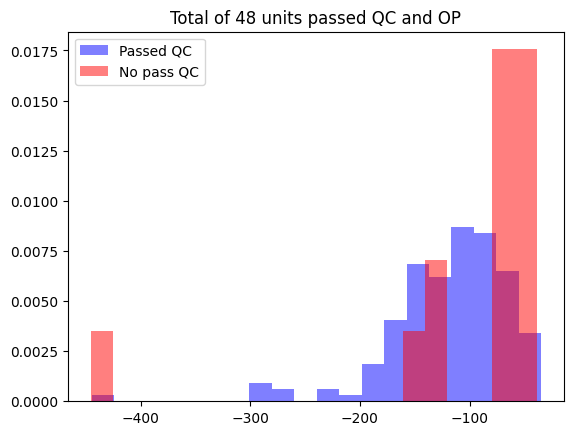

In [50]:
plt.hist(curated_all_wf_pass_qc['amplitude'], bins=20, alpha=0.5, color='blue', label='Passed QC', density=True);
plt.hist(curated_all_wf_nopass_qc['amplitude'], bins=20, alpha=0.5, color='red', label='No pass QC', density=True);
plt.title(f"Total of {len(curated_all_wf)} units passed QC and OP")
plt.legend()

In [36]:
curated_all_wf = combined_all_wf.query(
                                        'decoder_label != "noise" &'
                                        'isi_violations_ratio < @isi_threshold &'
                                        'firing_rate > @fr_range[0] &'
                                        'firing_rate < @fr_range[1] &'
                                        'presence_ratio > @presence_ratio &' 
                                        'amplitude_cutoff < @amplitude_cutoff &'
                                        'baseline_fr > @fr_baseline &'
                                        'opto_pass == True &'
                                        'amplitude <-80'
                                    )

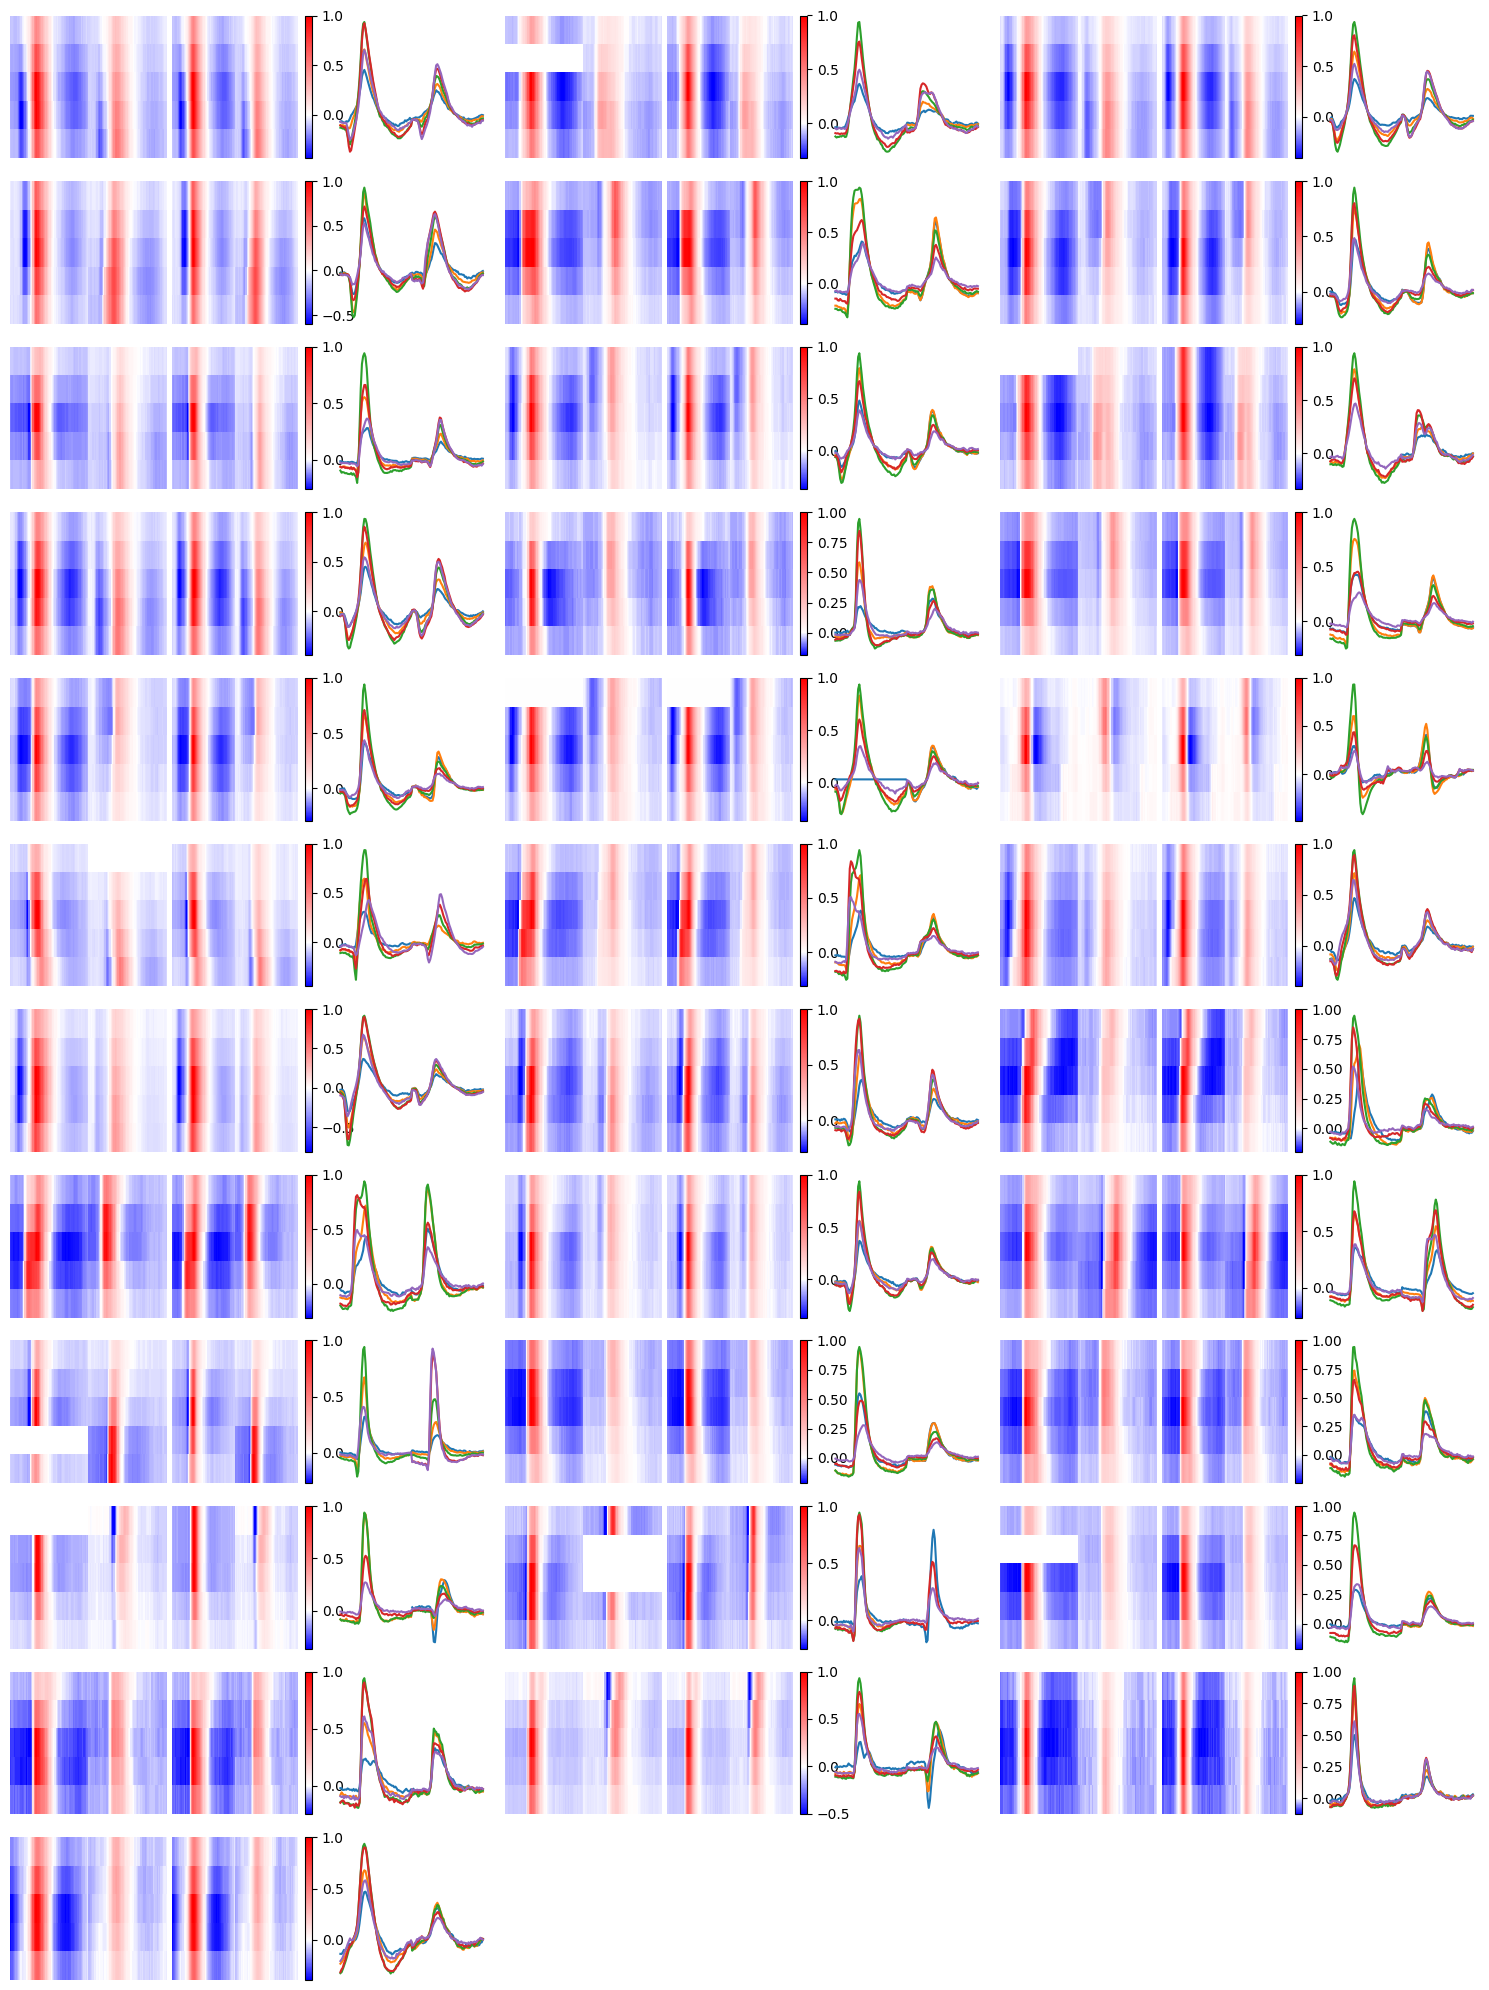

In [40]:
fig = plt.figure(figsize=(15, 20)) 
gs = gridspec.GridSpec(int(np.ceil(len(curated_all_wf)/int(np.round(np.sqrt(len(curated_all_wf))/2)))), int(np.round(np.sqrt(len(curated_all_wf))/2)), figure=fig)
for unit_ind in range(len(curated_all_wf) ):
    gs_sub = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[unit_ind])
    ax = fig.add_subplot(gs_sub[0])
    waveform = curated_all_wf['waveform'].values[unit_ind]
    shifted_cmap = shiftedColorMap(b_w_r_cmap, np.nanmin(waveform), np.nanmax(waveform), 'shifted_b_w_r');
    cax = ax.imshow(waveform, cmap=shifted_cmap, aspect='auto', interpolation='none');
    ax.axis('off')
    ax = fig.add_subplot(gs_sub[1])
    waveform_inter = curated_all_wf['waveform_inter'].values[unit_ind]
    ax.imshow(waveform_inter, cmap=shifted_cmap, aspect='auto', interpolation='none');
    ax.axis('off')
    fig.colorbar(cax, ax=ax)
    ax = fig.add_subplot(gs_sub[2])
    ax.plot(waveform.T);
    ax.axis('off')
    # ax = fig.add_subplot(gs[unit_ind])
    # # ax.set_title(f"Unit {curated_all_wf['ks_unit_id'].values[unit_ind]} Amplitude {curated_all_wf['amplitude'].values[unit_ind]}")

plt.tight_layout()
# plt.show()
# plt.savefig(os.path.join(make_combine_folder(exp_name = 'all_wf'), 'combined_waveforms.png'), dpi=300)

In [42]:
plt.savefig(os.path.join(combined_dirs['wf_figs_path'], 'combined_waveforms.pdf'), format = 'pdf')

<Figure size 640x480 with 0 Axes>